In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
first_date = session.query(Measurement.date).order_by(Measurement.date).first()

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#converting to date time then calculatig date veriance from today's date
new_last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
begin_date = new_last_date - dt.timedelta(days=365)
# print(begin_date)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
results = session.query(*sel).filter(Measurement.date >= begin_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(results, columns=['Date','Precipitation'])

#removing null values then setting date as index column
precipitation = precipitation.dropna(how='any')
precipitation = precipitation.set_index("Date")
# Sort the dataframe by date
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation.head()



,Precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


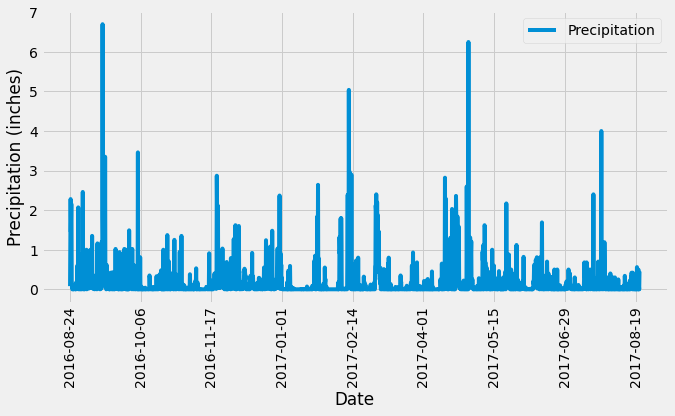

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
graph = precipitation.plot(rot = 90, xlabel='Date', ylabel = "Precipitation (inches)", figsize=(10,5))
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
total_count = station_count = session.query(Station.id).count() 
print(total_count)

9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station = 'USC00519281'

session.query(func.max(Measurement.tobs),
              func.min(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == station).all()

[(85.0, 54.0, 71.66378066378067)]

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]
station_temperatures = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= begin_date, Measurement.station == station).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

#converting list from query into dataframe
station_temperatures_df = pd.DataFrame(station_temperatures, columns=['Measurement Date','Temperature'])
station_temperatures_df.head()

,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


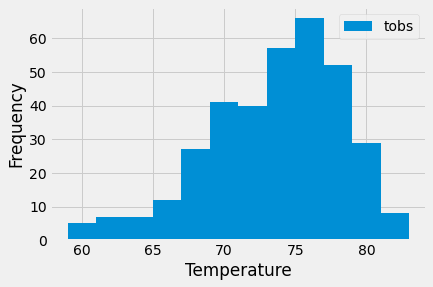

In [17]:
#plotting historgram using matplotlib
plt.hist(station_temperatures_df['Temperature'],bins=12, label= "tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.figsize=(15,15)
plt.legend()

# Close session

In [18]:
# Close Session
session.close()